In [5]:
# Installing Required Packages
# Website ------> "https://github.com/facebookresearch/segment-anything"

!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install torch torchvision opencv-python numpy


  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-kdtny5nu
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-kdtny5nu
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=ef301fddaefbd07dbf3fa1252a6b1e740166f900dac4fc43e6020e627c35029c
  Stored in directory: /tmp/pip-ephem-wheel-cache-av0p99y6/wheels/29/82/ff/04e2be9805a1cb48bec0b85b5a6da6b63f647645750a0e42d4
Successfully built segment_anything


In [10]:
# Create Sam Predictor
from segment_anything import SamPredictor, sam_model_registry
import os

model_path = './sam_vit_b_01ec64.pth'
if not os.path.exists(model_path):
 !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

sam = sam_model_registry["vit_b"](checkpoint=model_path)
predictor = SamPredictor(sam)

In [11]:
# load image and select x, y coordinates to test this function.
import cv2

image_path = './test.jpg'
if not os.path.exists(image_path):
 !wget https://utils-computervisiondeveloper.s3.amazonaws.com/media/public/test.jpg

x = 528 # coordinates of x
y = 606 # coordinates of y

image = cv2.imread(image_path)


--2025-09-10 00:24:31--  https://utils-computervisiondeveloper.s3.amazonaws.com/media/public/test.jpg
Resolving utils-computervisiondeveloper.s3.amazonaws.com (utils-computervisiondeveloper.s3.amazonaws.com)... 52.216.141.44, 52.217.135.209, 52.216.42.145, ...
Connecting to utils-computervisiondeveloper.s3.amazonaws.com (utils-computervisiondeveloper.s3.amazonaws.com)|52.216.141.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79560 (78K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  77.70K  --.-KB/s    in 0.06s   

2025-09-10 00:24:31 (1.32 MB/s) - ‘test.jpg’ saved [79560/79560]



In [13]:
# use sam predictor on (Image, x, y) to get location of the subject
import numpy as np

predictor.set_image(image)

masks, scores, logits = predictor.predict(
                                point_coords = np.asarray([[x,y]]),
                                point_labels = np.asarray([1]),
                                multimask_output = True
                                )

C, H, W = masks.shape

result_mask = np.zeros((H,W), dtype=bool)

for j in range(C):
  result_mask |= masks[j, :, :]
result_mask = result_mask.astype(np.uint8)

In [14]:
# remove the background.
alpha_channel = np.ones(result_mask.shape, dtype=result_mask.dtype) * 255

alpha_channel[result_mask == 0] = 0

result_mask = cv2.merge((image, alpha_channel))

In [15]:
# wrap it up as a function

import base64
import os

from segment_anything import SamPredictor, sam_model_registry
import cv2
import numpy as np


model_path = './sam_vit_b_01ec64.pth'
if not os.path.exists(model_path):
  !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

sam = sam_model_registry["vit_b"](checkpoint=model_path)
predictor = SamPredictor(sam)


def remove_background(image_base64_encoding, x, y):

  image_bytes = base64.b64decode(image_base64_encoding)

  image = cv2.imdecode(np.frombuffer(image_bytes, dtype=np.uint8), cv2.IMREAD_COLOR)

  predictor.set_image(image)

  masks, scores, logits = predictor.predict(
                                    point_coords=np.asarray([[x, y]]),
                                    point_labels=np.asarray([1]),
                                    multimask_output=True
                                )

  C, H, W = masks.shape

  result_mask = np.zeros((H, W), dtype=bool)

  for j in range(C):
    result_mask |= masks[j, :, :]

  result_mask = result_mask.astype(np.uint8)

  alpha_channel = np.ones(result_mask.shape, dtype=result_mask.dtype) * 255

  alpha_channel[result_mask == 0] = 0

  result_image = cv2.merge((image, alpha_channel))

  _, result_image_bytes = cv2.imencode('.png', result_image)

  result_image_bytes = result_image_bytes.tobytes()

  result_image_bytes_encoded_base64 = base64.b64encode(result_image_bytes).decode('utf-8')

  return result_image_bytes_encoded_base64

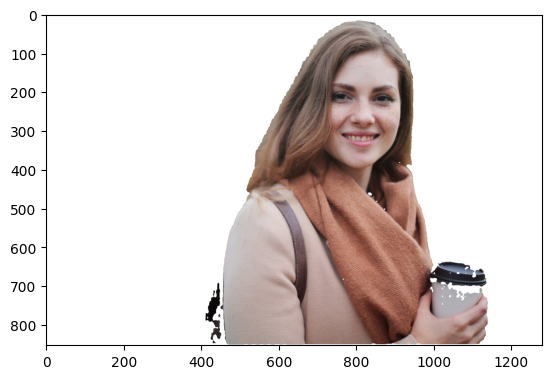

In [16]:
import cv2
import matplotlib.pyplot as plt


image_path = './test.jpg'
if not os.path.exists(image_path):
  !wget https://utils-computervisiondeveloper.s3.amazonaws.com/media/public/test.jpg

x = 528
y = 606

image = cv2.imread(image_path)

_, image_bytes = cv2.imencode('.png', image)

image_bytes = image_bytes.tobytes()

image_bytes_encoded_base64 = base64.b64encode(image_bytes).decode('utf-8')

result_image = remove_background(image_bytes_encoded_base64, x, y)

result_image_bytes = base64.b64decode(result_image)

result_image = cv2.imdecode(np.frombuffer(result_image_bytes, dtype=np.uint8), cv2.IMREAD_UNCHANGED)

plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGRA2RGBA))
plt.show()

In [17]:
!pip install modelbit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 103.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4